In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import TensorDataset, DataLoader



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 75)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
def train(autoencoder, data, epochs=5):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for batch in data:
            x = batch[0]
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [9]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = np.load(r'/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy' )
data = data[:, 0, :] #Format to one of the states
print(data.shape)

data = np.expand_dims(data, axis=1) #
print(data.shape)

#Convert to pytorch tensor
data_tensor = torch.from_numpy(data).float()

dataset = TensorDataset(data_tensor)

dataloader = DataLoader(dataset, batch_size=99, shuffle=True)

autoencoder = train(autoencoder, dataloader)

(299400, 75)
(299400, 1, 75)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (99x75 and 784x512)

In [10]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

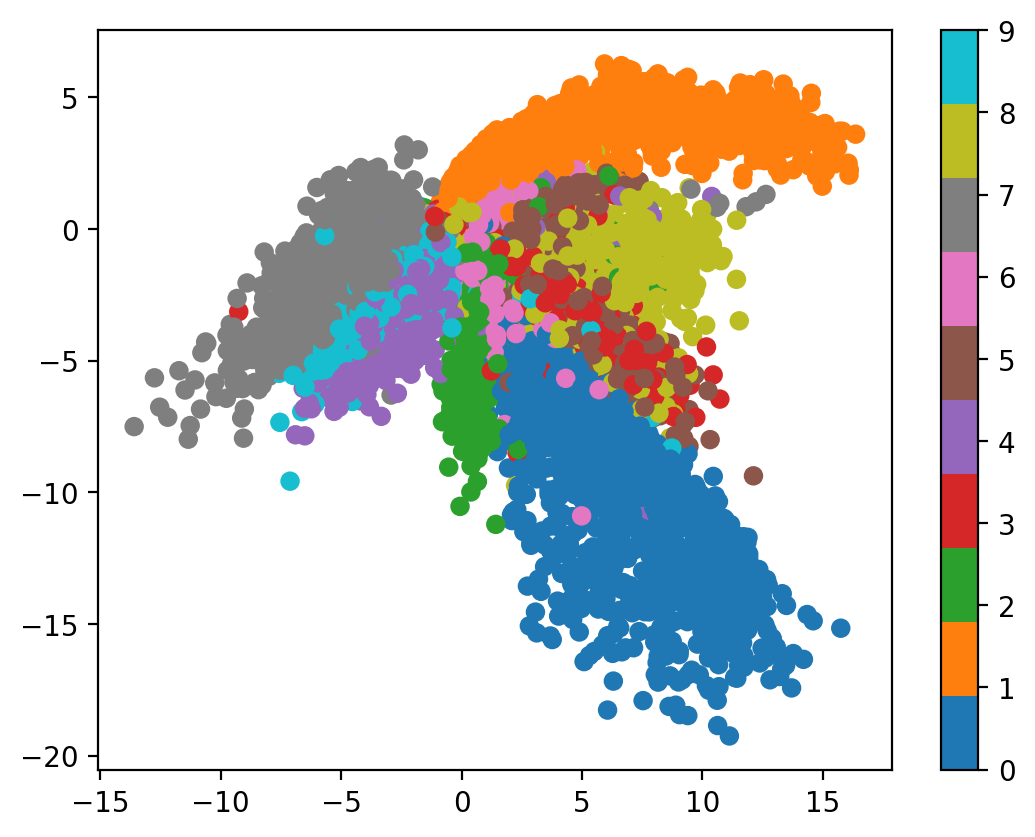

In [13]:
plot_latent(autoencoder, data)

In [14]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

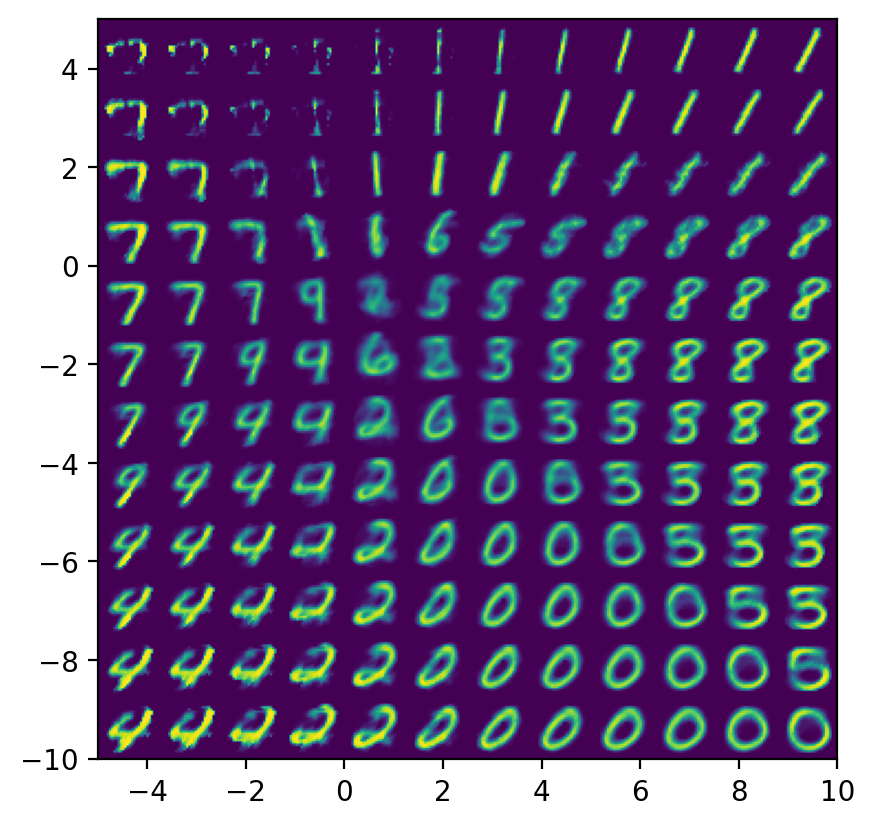

In [17]:
plot_reconstructed(autoencoder)

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [17]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [16]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [18]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

ValueError: not enough values to unpack (expected 2, got 1)

Let's plot the latent vector representations of a few batches of data.

In [19]:
plot_latent(vae, data)

ValueError: not enough values to unpack (expected 2, got 1)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

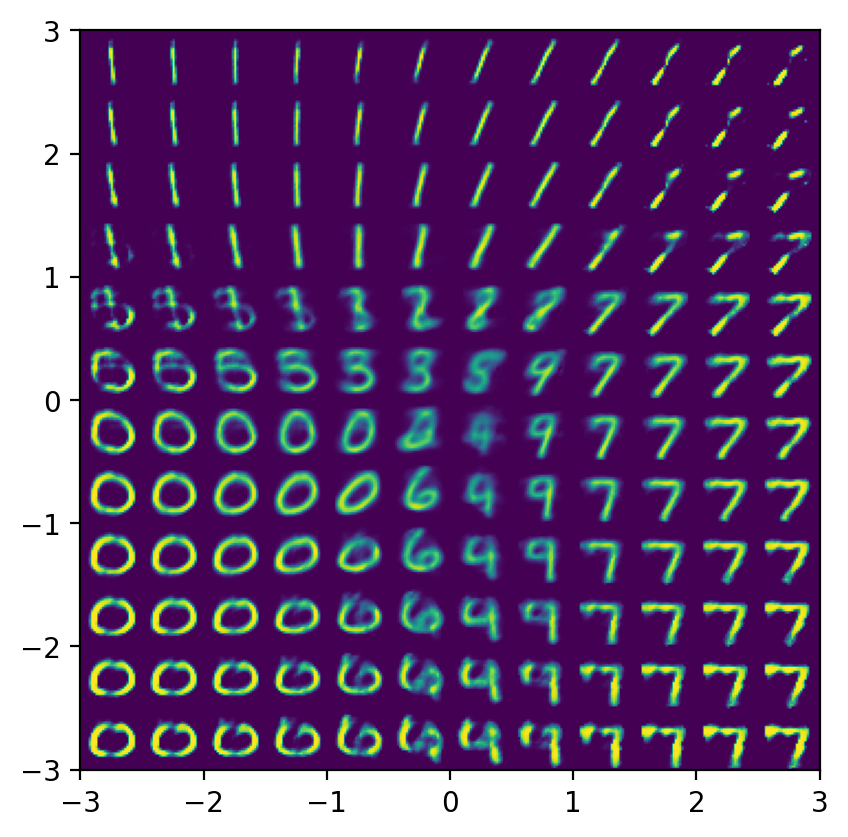

In [24]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

# Extra Fun

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [39]:
# def interpolate(autoencoder, x_1, x_2, n=12):
#     z_1 = autoencoder.encoder(x_1)
#     z_2 = autoencoder.encoder(x_2)
#     z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
#     interpolate_list = autoencoder.decoder(z)
#     interpolate_list = interpolate_list.to('cpu').detach().numpy()

#     w = 28
#     img = np.zeros((w, n*w))
#     for i, x_hat in enumerate(interpolate_list):
#         img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])

In [ ]:
# x, y = data.__iter__().next() # hack to grab a batch
# x_1 = x[y == 1][1].to(device) # find a 1
# x_2 = x[y == 0][1].to(device) # find a 0

AttributeError: 'iterator' object has no attribute 'next'

In [37]:
# interpolate(vae, x_1, x_2, n=20)

In [ ]:
# interpolate(autoencoder, x_1, x_2, n=20)

I also wanted to write some code to generate a GIF of the transition, instead of just a row of images. The code below modifies the code above to produce a GIF.

In [ ]:
# from PIL import Image

# def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
#     z_1 = autoencoder.encoder(x_1)
#     z_2 = autoencoder.encoder(x_2)
    
#     z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
#     interpolate_list = autoencoder.decoder(z)
#     interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
#     images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
#     images_list = images_list + images_list[::-1] # loop back beginning
    
#     images_list[0].save(
#         f'{filename}.gif', 
#         save_all=True, 
#         append_images=images_list[1:],
#         loop=1)

In [ ]:
# interpolate_gif(vae, "vae", x_1, x_2)

<img src="vae.gif">

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)